In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pathlib
import pandas as pd
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

%matplotlib inline

### Load the image data

In [3]:
data_dir = 'rice_photos/'

In [4]:
# Check the image size
image = PIL.Image.open('rice_photos/Arborio/Arborio (1).jpg')
width, height = image.size
print(width, height)

250 250


In [5]:
batch_size = 64
img_height = 250
img_width = 250

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


2022-05-19 21:33:47.805123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 21:33:47.881640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 21:33:47.881797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 21:33:47.884015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


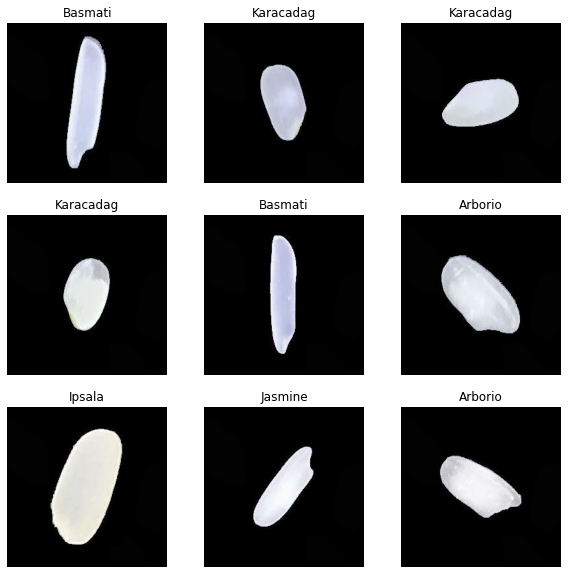

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Preprocess the data

In [10]:
preprocessed_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
preprocessed_ds = train_ds.map(lambda x, y: (preprocessed_layer(x), y))
image_batch, labels_batch = next(iter(preprocessed_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

### Train the model

##### Convolutional neural network model by using function API

In [13]:
# Train the model using function API
num_classes = len(class_names)

def convolutional_model(input_shape):

    img_input = tf.keras.Input(shape=(input_shape))

    Z1 = tfl.Conv2D(32,(4,4),strides=1,padding='same')(img_input)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(A1)
    Z2 = tfl.Conv2D(16,(2,2),strides=1,padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(A2)
    F = tfl.Flatten()(P2)
    outputs = tfl.Dense(num_classes, activation='softmax')(F)

    model = tf.keras.Model(inputs=img_input, outputs=outputs)
    return model

conv_model = convolutional_model((250, 250, 3))

conv_model.compile(optimizer = 'adam',
                   loss = tf.losses.SparseCategoricalCrossentropy(),
                   metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True )                  

conv_model.summary()

history = conv_model.fit(train_ds, epochs = 10, validation_data=val_ds, callbacks=[callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 32)      1568      
                                                                 
 re_lu (ReLU)                (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2064      
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 16)        0         
                                                             

2022-05-19 21:34:09.159104: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-05-19 21:34:10.737622: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 44s 44ms/step - loss: 0.5001 - accuracy: 0.9097 - val_loss: 0.0780 - val_accuracy: 0.9745
Epoch 2/10
938/938 [==============================] - 42s 45ms/step - loss: 0.0780 - accuracy: 0.9738 - val_loss: 0.0613 - val_accuracy: 0.9774
Epoch 3/10
938/938 [==============================] - 42s 44ms/step - loss: 0.0563 - accuracy: 0.9809 - val_loss: 0.0336 - val_accuracy: 0.9892
Epoch 4/10
938/938 [==============================] - 42s 44ms/step - loss: 0.0486 - accuracy: 0.9833 - val_loss: 0.0540 - val_accuracy: 0.9823
Epoch 5/10
938/938 [==============================] - 42s 45ms/step - loss: 0.0507 - accuracy: 0.9834 - val_loss: 0.0397 - val_accuracy: 0.9871
Epoch 6/10
938/938 [==============================] - 42s 45ms/step - loss: 0.0356 - accuracy: 0.9885 - val_loss: 0.0530 - val_accuracy: 0.9856


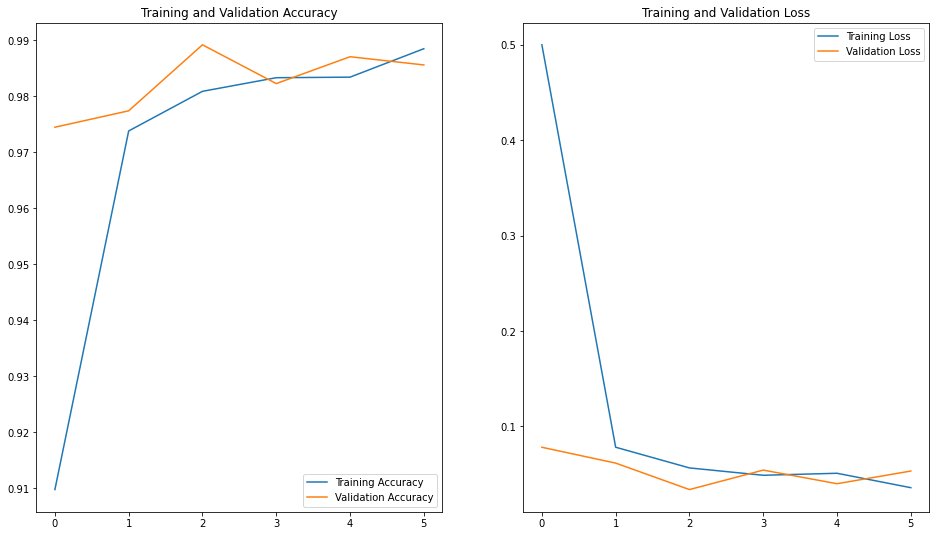

In [17]:
# Visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Train the model again with dropout
num_classes = len(class_names)

def convolutional_model(input_shape):

    img_input = tf.keras.Input(shape=(input_shape))

    Z1 = tfl.Conv2D(32,(4,4),strides=1,padding='same')(img_input)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(A1)
    Z2 = tfl.Conv2D(16,(2,2),strides=1,padding='same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(A2)
    D = tfl.Dropout(0.2)(P2)
    F = tfl.Flatten()(D)
    outputs = tfl.Dense(num_classes, activation='softmax')(F)

    model = tf.keras.Model(inputs=img_input, outputs=outputs)
    return model

conv_model = convolutional_model((250, 250, 3))

conv_model.compile(optimizer = 'adam',
                   loss = tf.losses.SparseCategoricalCrossentropy(),
                   metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True )                  

conv_model.summary()

history = conv_model.fit(train_ds, epochs = 10, validation_data=val_ds, callbacks=[callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 32)      1568      
                                                                 
 re_lu_2 (ReLU)              (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2064      
                                                                 
 re_lu_3 (ReLU)              (None, 32, 32, 16)        0         
                                                           

In [ ]:
# The accuracy and val_accuracy are almost the same as the previous model without dropput layer, both of them have achived quite good result.

In [19]:
# Save the trained weights
conv_model.save('train_conv_model')

INFO:tensorflow:Assets written to: train_conv_model/assets


INFO:tensorflow:Assets written to: train_conv_model/assets


#### Mobilenetv2 model


In [20]:
# Create the model with Mobilenetv2 and freeze the top layers to train
mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg')

for layer in mobilenet.layers:
    layer.trainable = False

mobilenet = tf.keras.Sequential([mobilenet,
                              tfl.Flatten(),
                              tfl.Dropout(0.3),
                              tfl.Dense(num_classes, activation='softmax')])

mobilenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
               loss = tf.losses.SparseCategoricalCrossentropy(),
               metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 3,
                                            restore_best_weights = True)                  

mobilenet.summary()

history = mobilenet.fit(train_ds, epochs = 10, validation_data=val_ds, callbacks=[callback])


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
938/938 [=========================

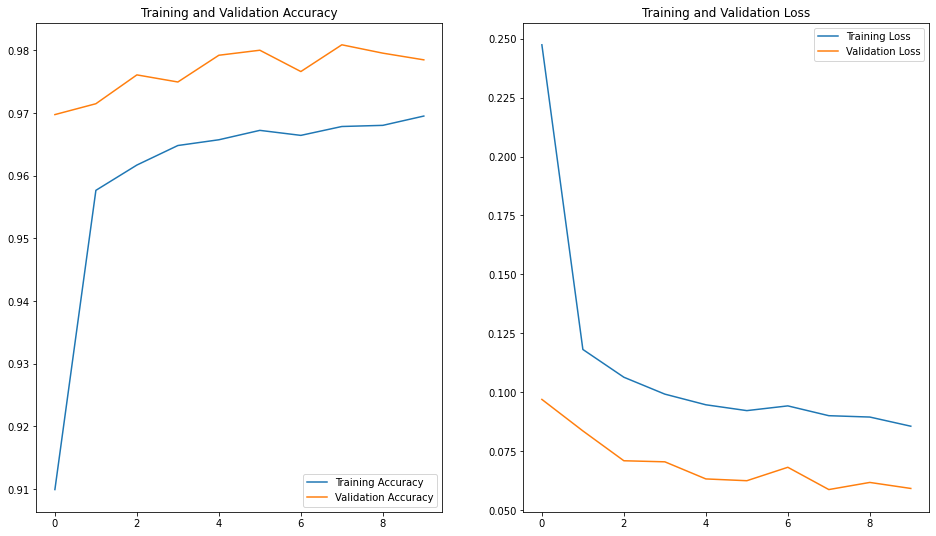

In [21]:
# Visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()